In [ ]:
!git clone https://github.com/Ryzhtus/datavizmipt

In [ ]:
!pip install pygraphml
!pip install networkx

In [161]:
%matplotlib inline

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from scipy.optimize import linprog

In [190]:
def coffman_graham(graph: nx.DiGraph, width: int, return_layers: bool):
    # step 1: topological sort
    pi = {node: i for i, node in enumerate(list(nx.lexicographical_topological_sort(graph)))}

    # step 2: greedy layering
    V = set(graph.nodes())
    U = set()
    L = [set()]
    
    while len(U) != len(graph.nodes()):
        u = None
        pi_u = -float('inf')

        for node in V:
            if set(nx.neighbors(graph, node)):
                subset_bool = set(nx.neighbors(graph, node)) <= U
            else: 
                subset_bool = True

            if subset_bool and pi[node] > pi_u:
                u = node
                pi_u = pi[node]

        if len(L[-1]) == width or bool(set(nx.neighbors(graph, u)).intersection(L[-1])):
            L.append(set())
            
        L[-1].add(u)
        V.remove(u)
        U.add(u)

    for layer_number, layer in enumerate(L):
        for node_number, node in enumerate(layer):
            graph.nodes[node]['x'] = node_number
            graph.nodes[node]['y'] = layer_number


def dummy_verticies(graph: nx.DiGraph, return_layers: bool):
    A = []
    b = [-1 for edge in list(graph.edges())]
    c = [0 for node in list(graph.nodes())]
    
    for edge in list(graph.edges()):
        coefficients = [0 for node in list(graph.nodes())]
        coefficients[int(edge[0][1:])] = -1
        coefficients[int(edge[1][1:])] = 1
        c[int(edge[0][1:])] += 1
        c[int(edge[1][1:])] -= 1
        A.append(coefficients)

    bounds = [(0, float('inf')) for node in list(graph.nodes())]
    
    result = linprog(c=c, A_ub=A, b_ub=b, bounds=bounds, method='revised simplex')['x']

    L = [set() for layer in range(int(max(result)) + 1)]

    for layer_number, layer in enumerate(result):
         L[int(result[layer_number])].add(list(graph.nodes())[layer_number])
    
    if return_layers:
        for layer_number, layer in enumerate(L):
            for node_number, node in enumerate(layer):
                graph.nodes[node]['y'] = layer_number
        
        return L
    else:
        for layer_number, layer in enumerate(L):
            for node_number, node in enumerate(layer):
                graph.nodes[node]['x'] = node_number
                graph.nodes[node]['y'] = layer_number

def add(graph: nx.DiGraph, L: list):
    dummy_id = 0

    for edge in list(graph.edges()):
        if graph.nodes[edge[0]]['y'] - graph.nodes[edge[1]]['y'] > 1:
            node_start, node_end = edge[0], edge[1]
            y_start, y_end = graph.nodes[edge[0]]['y'], graph.nodes[edge[1]]['y']
            graph.remove_edge(node_start, node_end)

            for layer_number in range(y_start - 1, y_end, -1):
                name = 'd' + str(dummy_id)
                L[layer_number].add(name)
                dummy_id += 1

                graph.add_node(name)
                graph.add_edge(node_start, name)

                node_start = name

            graph.add_edge(node_start, node_end)
    
    for layer_number, layer in enumerate(L):
            for node_number, node in enumerate(layer):
                graph.nodes[node]['x'] = node_number
                graph.nodes[node]['y'] = layer_number

def reduce_crossings(graph: nx.DiGraph):
    pass

In [224]:
def draw(graph_path: str, width: int) -> None:
    graph = nx.read_graphml(graph_path)
    
    if width is not None:
        L = coffman_graham(graph, width, return_layers=True)
    else:
        L = dummy_verticies(graph, return_layers=True)
    
    add(graph, L)
    
    coordinates = {}
    node_sizes = []
    for node in list(graph.nodes):
        coordinates[node] = (graph.nodes[node]['x'], graph.nodes[node]['y'])
        if node[0] == 'd':
            node_sizes.append(0)
        else:
            node_sizes.append(300)


    plt.figure(figsize=(5, 5))
    nx.draw(graph, pos=coordinates, with_labels=False, node_size=node_sizes)

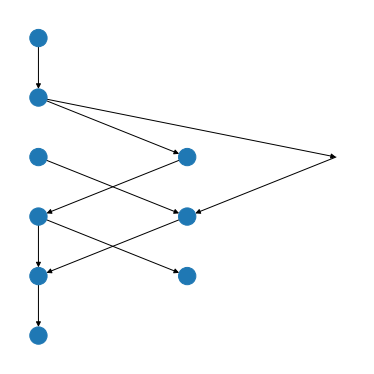

In [226]:
draw('graphs/flow-9n.xml', width=None)